# Natural gradient-based optimizer

In this notebook, you will learn how to use an advanced plugin for variational optimization.

This plugin can perform a **gradient-descent optimization** based on the computation of the exact gradient of the energy with respect to the variational parameters, as well as the more advanced **'natural-gradient' optimization**.

## Description of the variational task

Here, we want to minimize the value of $\langle Y_0 \rangle$ with a simple ansatz described in the cell below:

In [1]:
import numpy as np
from qat.core import Observable, Term
from qat.lang.AQASM import Program, RX, RY, RZ, CNOT

nbqbits = 2

obs = Observable(nbqbits, pauli_terms=[Term(1, "Y", [0])])

prog = Program()
reg = prog.qalloc(nbqbits)

RY(np.pi / 4)(reg[0])
RY(np.pi / 3)(reg[1])
RZ(prog.new_var(float, "\\theta_0"))(reg[0])
RZ(prog.new_var(float, "\\theta_1"))(reg[1])
CNOT(reg[0], reg[1])
RY(prog.new_var(float, "\\theta_2"))(reg[1])
CNOT(reg[0], reg[1])

circ = prog.to_circ()

Let us plot the circuit.

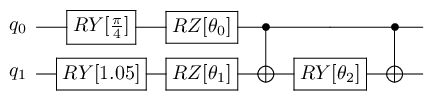

In [2]:
circ.display()

## Initializing the plugin

We now instantiate the plugin first with a simple gradient descent, and then with the natural gradient.

In [3]:
import time
from qat.qpus import get_default_qpu
from qat.plugins import GradientDescentOptimizer

res = {}

step = 0.3

# Count number of variational parameters
n_parameters = len(circ.get_variables())

#  Define initial parameters values
x0 = np.array([0.2, 0.1, 0.1])

# Initialize Optimizer
natgrad_plugin = GradientDescentOptimizer(maxiter=100, lambda_step=step, natural_gradient=True, x0=x0, tol=1e-5)
grad_plugin = GradientDescentOptimizer(maxiter=100, lambda_step=step, natural_gradient=False, x0=x0, tol=1e-5)

# Define which QPU to use
qpu = get_default_qpu()

# Define the stack
natgrad_stack = natgrad_plugin | qpu
grad_stack = grad_plugin | qpu

## Launch the optimization

In [4]:
res["natural gradient"] = natgrad_stack.submit(circ.to_job(job_type="OBS", observable=obs))
res["gradient descent"] = grad_stack.submit(circ.to_job(job_type="OBS", observable=obs))

## Comparing to other plugins

For comparison, we also run the same optimization with other variational plugins from the QLM:

In [5]:
from qat.plugins import ScipyMinimizePlugin, PSOMinimizePlugin, SPSAMinimizePlugin

# Here again initial parameters are randomly chosen
methods = ["COBYLA", "BFGS", "PSO", "SPSA"]
plugins = {
    "COBYLA": ScipyMinimizePlugin(method="COBYLA", x0=x0),
    "BFGS": ScipyMinimizePlugin(method="BFGS", x0=x0),
    "PSO": PSOMinimizePlugin(),
    "SPSA": SPSAMinimizePlugin(x0=x0),
}
for method in methods:
    stack = plugins[method] | qpu
    res[method] = stack.submit(circ.to_job(job_type="OBS", observable=obs))

## Plotting the results

We can plot the trace of each optimization we performed and compare their performances.

final value (COBYLA): -0.707106775793603
final value (BFGS): -0.7071067811864411
final value (PSO): -0.6538448149312068
final value (SPSA): -0.7067710797856288
final value (natural gradient): -0.7071067811461207
final value (gradient descent): -0.707106781153533


(0.0, 40.0)

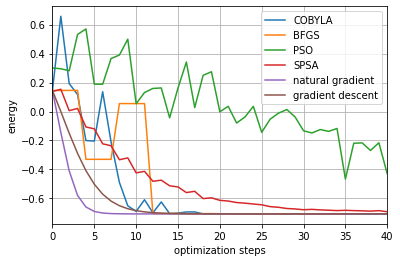

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

for method in ["COBYLA", "BFGS", "PSO", "SPSA", "natural gradient", "gradient descent"]:
    print(f"final value ({method}): {res[method].value}")
    vals = res[method].meta_data["optimization_trace"]
    plt.plot(eval(vals) if isinstance(vals, str) else vals, label=method)
plt.legend()
plt.grid()
plt.ylabel("energy")
plt.xlabel("optimization steps")
plt.xlim(0, 40)